# Foreign Gifts and Contracts to Columbia University

_Source: [Foreign Gifts and Contracts Report](https://catalog.data.gov/dataset/foreign-gifts-and-contracts-report-2011) from the Office of Federal Student Aid (last updated August 9, 2018)._

In [1]:
%%capture

from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime

matplotlib.rcParams.update({'font.size': 14})
plt.tight_layout()

Let's read in the data. We filter out any gifts that weren't given to Columbia University.

In [3]:
df = pd.read_excel('../data/ForeignGifts.xlsx')
df.columns = df.iloc[0]
df.set_index('ID')
df = df.iloc[1:]
df = df[df['Institution Name'] == 'Columbia University in the City of New York']
df['Foreign Gift Amount'] = pd.to_numeric(df['Foreign Gift Amount'])
df['Foreign Gift Received Date'] = pd.to_datetime(df['Foreign Gift Received Date'])

COUNTRIES = df['Country of Giftor'].unique()

# Raw Numbers

Let's take a look at the total donations from each country to Columbia. I've sorted them from least to greatest, and I've split them into monetary gifts and contracts.

In [57]:
# Returns two dictionaries: monetary gifts and contracts.
# Key: Country name; value: total gift amount
def getGifts():
    monetaryGifts = defaultdict(int)
    contracts = defaultdict(int)

    for _, gift in df.iterrows():
        country = gift['Country of Giftor']
        amount = gift['Foreign Gift Amount']
        if gift['Gift Type'] == 'Monetary Gift':
            monetaryGifts[ country ] += amount
        else:
            contracts[ country ] += amount
    return [monetaryGifts, contracts]

def getGiftsByCountry(countries=COUNTRIES, doSort=False, sortByMonetary=True, sortByContracts=True):
    filterByCountry = lambda gifts: [gifts[c] for c in countries]
    
    [monetaryGifts, contracts] = [
        filterByCountry(giftList) for giftList in getGifts()
    ]
    
    def countrySum(tup):
        (monetary, contract, country) = tup
        output = 0
        if sortByMonetary: output += monetary
        if sortByContracts: output += contract
        return output
    
    output = [monetaryGifts, contracts, countries]
    if doSort:
        output = zip(*sorted(zip(*output), key=countrySum))
    return output

In [58]:
def drawGifts(showMonetary=False, showContracts=False):
    if not showMonetary and not showContracts:
        showMonetary = showContracts = True
        
    [monetaryGifts, contracts, countries] = getGiftsByCountry(
        doSort=True, 
        sortByMonetary=showMonetary,
        sortByContracts=showContracts,
    )

    fig, ax = plt.subplots(figsize=(13,13))
    indices = np.arange(len(countries))

    width = 1
    bottom = None
    legend = []
    if showMonetary:
        p = ax.bar(indices, monetaryGifts, width, color='#d62728', edgecolor='black')
        legend.append((p[0], 'Monetary Gift'))
        bottom = monetaryGifts
    if showContracts:
        p = ax.bar(indices, contracts, width, bottom=bottom, edgecolor='black')
        legend.append((p[0], 'Contract'))
        
    plt.legend(*zip(*legend))

    plt.xticks(indices, countries)

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.set(xlabel='Country of Giftor', ylabel='Foreign Gift Amount',
           title='Foreign Gifts to Columbia University by Country and Gift Type')
    ax.grid()

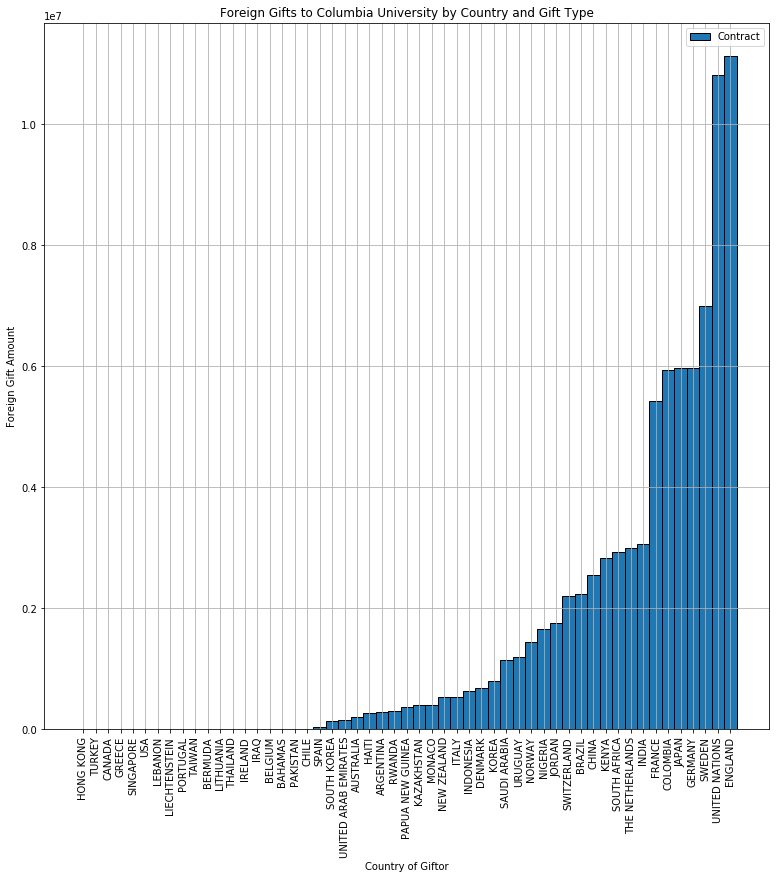

In [61]:
drawGifts(showContracts=True)

# Time Series

Let's now take a look at the gifts over time, first from the top 10 giftor countries.

In [28]:
def getGiftsWithDate(country):
    dates = []
    amounts = []
    for _, gift in df[df['Country of Giftor'] == country].iterrows():
        dates.append(gift['Foreign Gift Received Date'])
        amounts.append(gift['Foreign Gift Amount'])
    return [dates, amounts]

In [53]:
def lineGifts(plot, country):
    [dates, amounts] = getGiftsWithDate(country)
    plot.plot(dates, amounts, marker='.', label=country)
    plot.set_title(country)
    plot.set(xlabel='Date', ylabel='Foreign Gift Amount')
    plot.legend()
    plot.grid()
    plot.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
    )
    datemin = datetime.date(2013, 1, 1)
    datemax = datetime.date(2019, 1, 1)
    plot.set_xlim(datemin, datemax)
    
def getTopCountries(limit=10):
    [_, _, countries] = getGiftsByCountry(doSort=True)
    return countries[-1:-limit:-1]

def drawCountry(country):    
    fig, ax = plt.subplots(figsize=(10, 10))
    lineGifts(ax, country)

In [54]:
top10 = getTopCountries()
# ('ENGLAND', 'BRAZIL', 'HONG KONG', 'CHINA', 'JAPAN', 'SWITZERLAND', 'UNITED NATIONS', 'GERMANY', 'SWEDEN')

Let's take a look at these 10 countries.

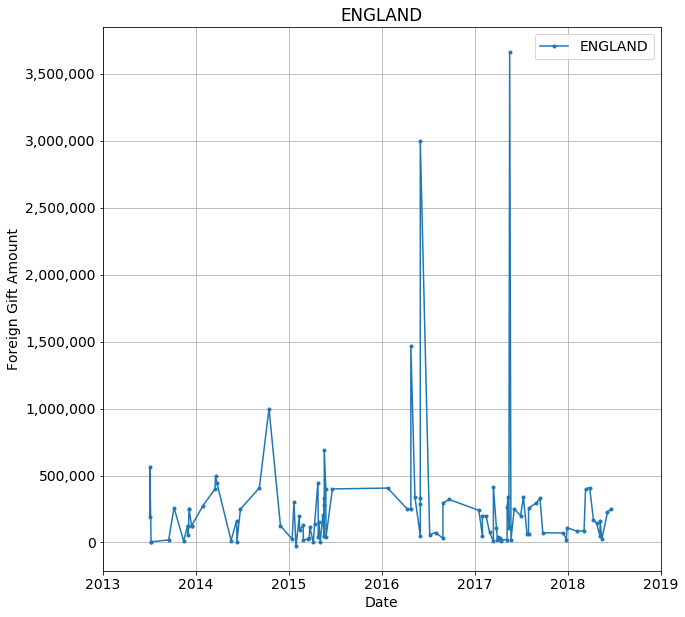

In [61]:
drawCountry('ENGLAND')

# England

UNILEVER: Industry affiliate with DSI

CENTRE FOR ECONOMIC POLICY RESEARCH: Not found. Could just be research contracts/etc.

Afren PLC: In May 2013, a [SIPA team](http://admissionsblog.sipa.columbia.edu/tag/afren-plc/)'s capstone project was a case study with Afren. _So they were paid?_

The Gatsby Charitable Foundation: gives grants to CU students to support non-curricular arts projects

# Brazil

Many Brazillian gifts are monetary gifts from the Lemann Foundation, which is run by Jorge Lemann, Brazil's richest man.